In [1]:
from matplotlib import pylab
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context='poster', style='dark')

pylab.rcParams['figure.figsize'] = (24.0, 18.0)

import numpy as np
from numpy.random import rand
import pandas as pd

from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import time

pd.set_option('display.max_columns', 500)

In [2]:
def try_model(X, Y, model):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=10)

    print("start fitting... ", time.ctime().split()[3])
    model.fit(X_train, y_train)
    print("done fitting... ", time.ctime().split()[3])

    mse = mean_squared_error(y_test, model.predict(X_test))
    print('mean squared error: ', mse)

    print("explained variance score: ", explained_variance_score(np.abs(y_test), np.abs(model.predict(X_test))))

In [3]:
#importing and munging the data

#importing providers_info
providers_info = pd.read_csv('providers.csv')
providers_info = providers_info[0:2884]                          # removing NA values at the end
providers_info.columns = ['practice_id', 'provider_id', 'specialty', 'provider_level', 'tenure']

key_id = providers_info.practice_id + providers_info.provider_id / 100

# print key_id

providers_info['key_id'] = key_id
providers_info = providers_info[['key_id', 'practice_id', 'provider_id', 'specialty', 'provider_level', 'tenure']]

# providers_info.head(50)

# importing work_data

work_data = pd.read_csv('work.csv')
work_data = work_data[0:29974]
work_data.columns = ['practice_id', 'provider_id', 'obs_month', 'variable', 'value']

key_id = work_data.practice_id + work_data.provider_id / 100

work_data['key_id'] = key_id

work_data_nested = work_data.set_index(['practice_id', 'provider_id', 'obs_month', 'variable', 'key_id']).unstack('variable')
work_data = pd.DataFrame(work_data_nested.reset_index())
work_data = work_data.rename(columns = {'value': 'work_vals'})

# work_data.head()

#importing emr_touches and adding to global_df

emr_touches = pd.read_csv('emr_touches.csv')
emr_touches = emr_touches[0:14987]
emr_touches.columns = ['practice_id', 'provider_id', 'obs_month', 'keystrokes', 'mousestrokes']

# emr_touches.tail(10)

global_df = emr_touches
global_df['encounters'] = work_data.work_vals.Encounters
global_df['RVUs'] = work_data.work_vals.RVUs

# global_df.tail(10)

#importing emr_time

emr_time = pd.read_csv('emr_time.csv')
emr_time = emr_time[0:59948]

emr_time.columns = ['practice_id', 'provider_id', 'obs_month', 'variable', 'value']
emr_time_nested = emr_time.set_index(['practice_id', 'provider_id', 'obs_month', 'variable']).unstack('variable')

emr_time = pd.DataFrame(emr_time_nested.reset_index())
emr_time = emr_time.rename(columns = {'value': 'EMR_time'})

global_df['exam_emr'] = emr_time.EMR_time['Time Exam']
global_df['intake_emr'] = emr_time.EMR_time['Time Intake']
global_df['postvisit_emr'] = emr_time.EMR_time['Time Postvisit']
global_df['signoff_emr'] = emr_time.EMR_time['Time Signoff']
global_df['key_id'] = global_df.practice_id + global_df.provider_id / 100

#final merge
temp_df = global_df
total_df = pd.merge(temp_df[['key_id','obs_month', 'keystrokes', 'mousestrokes', 'encounters', 'RVUs', 'exam_emr', 'intake_emr',\
                             'postvisit_emr', 'signoff_emr']], providers_info, on = 'key_id')

#calculating stats

total_df['total_emr'] = total_df.exam_emr + total_df.intake_emr + total_df.postvisit_emr + total_df.signoff_emr
total_df['encounters'] = total_df.encounters.replace(0, np.nan) #replacing encounters = 0 with nan
total_df['grand_mee'] = total_df.total_emr / total_df.encounters # mee = Mean (total_Emr_time / Encounter)
total_df['exam_emr_enc'] = total_df.exam_emr / total_df.encounters
total_df['intake_emr_enc'] = total_df.intake_emr / total_df.encounters
total_df['postvisit_emr_enc'] = total_df.postvisit_emr / total_df.encounters
total_df['signoff_emr_enc'] = total_df.signoff_emr / total_df.encounters

total_df['RVUs_enc'] = total_df.RVUs / total_df.encounters

total_df['key_min'] = total_df.keystrokes / total_df.total_emr
total_df['mouse_min'] = total_df.mousestrokes / total_df.total_emr

total_df['key_enc'] = total_df.keystrokes / total_df.encounters
total_df['mouse_enc'] = total_df.mousestrokes / total_df.encounters

total_df = total_df[['key_id', 'obs_month', 'specialty', 'provider_level', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc', \
                     'postvisit_emr_enc', 'signoff_emr_enc',\
                     'key_min', 'mouse_min', 'key_enc', 'mouse_enc',\
                     'encounters', 'RVUs_enc', 'exam_emr', 'intake_emr', 'postvisit_emr', 'signoff_emr', \
                     'tenure', 'practice_id', 'provider_id', 'keystrokes', 'mousestrokes', 'RVUs', 'total_emr']]
total_df.drop('key_id', 1, inplace=True)
print(total_df.shape)
total_df.head(10)
# total_df.describe()

(15998, 25)


,obs_month,specialty,provider_level,grand_mee,intake_emr_enc,exam_emr_enc,postvisit_emr_enc,signoff_emr_enc,key_min,mouse_min,key_enc,mouse_enc,encounters,RVUs_enc,exam_emr,intake_emr,postvisit_emr,signoff_emr,tenure,practice_id,provider_id,keystrokes,mousestrokes,RVUs,total_emr
0,1,PCP,MD,11.122500,0.158102,8.874769,1.702407,0.387222,61.223496,7.693364,680.958333,85.569444,216,2.373519,1916.95,34.15,367.72,83.64,57,1,1,147087,18483,512.68,2402.46
1,2,PCP,MD,11.544661,0.351873,8.884422,1.986773,0.321594,65.139369,7.520766,752.011952,86.824701,251,2.232629,2229.99,88.32,498.68,80.72,57,1,1,188755,21793,560.39,2897.71
2,3,PCP,MD,11.730539,0.132963,9.532155,1.860438,0.204983,65.474444,7.550008,768.050505,88.565657,297,1.933973,2831.05,39.49,552.55,60.88,57,1,1,228111,26304,574.39,3483.97
3,4,PCP,MD,11.111716,0.084067,8.980187,1.866418,0.181045,62.074790,7.396724,689.757463,82.190299,268,2.304739,2406.69,22.53,500.20,48.52,57,1,1,184855,22027,617.67,2977.94
4,5,PCP,MD,12.033948,0.081255,10.027048,1.707196,0.218450,63.664602,7.725071,766.136531,92.963100,271,2.491107,2717.33,22.02,462.65,59.20,57,1,1,207623,25193,675.09,3261.20
5,6,PCP,MD,10.320464,0.101750,8.400036,1.567750,0.250929,67.376537,7.602786,695.357143,78.464286,280,2.499000,2352.01,28.49,438.97,70.26,57,1,1,194700,21970,699.72,2889.73
6,1,PCP,MD,13.838904,0.000000,9.295000,4.459589,0.084315,103.261601,5.133929,1429.027397,71.047945,146,2.209041,1357.07,0.00,651.10,12.31,57,1,2,208638,10373,322.52,2020.48
7,2,PCP,MD,15.011773,0.000000,10.296667,4.502695,0.212411,100.102048,5.297497,1502.709220,79.524823,141,2.459078,1451.83,0.00,634.88,29.95,57,1,2,211882,11213,346.73,2116.66
8,3,PCP,MD,16.074286,0.000000,11.298067,4.651429,0.124790,99.535246,5.501244,1599.957983,88.428571,119,1.802269,1344.47,0.00,553.52,14.85,57,1,2,190395,10523,214.47,1912.84
9,4,PCP,MD,15.386704,0.000000,9.639888,5.705363,0.041453,105.356871,5.058056,1621.094972,77.826816,179,1.707374,1725.54,0.00,1021.26,7.42,57,1,2,290176,13931,305.62,2754.22


In [4]:
total_df.tail()

,obs_month,specialty,provider_level,grand_mee,intake_emr_enc,exam_emr_enc,postvisit_emr_enc,signoff_emr_enc,key_min,mouse_min,key_enc,mouse_enc,encounters,RVUs_enc,exam_emr,intake_emr,postvisit_emr,signoff_emr,tenure,practice_id,provider_id,keystrokes,mousestrokes,RVUs,total_emr
15993,2,Surgery,MD,0.229045,0.002611,0.020828,0.205605,0,7.703003,36.985539,1.764331,8.471338,157,6.615924,3.27,0.41,32.28,0,30,199,2,277,1330,1038.70,35.96
15994,5,Surgery,MD,0.223832,0.000000,0.000000,0.223832,0,0.428036,35.393258,0.095808,7.922156,167,6.124551,0.00,0.00,37.38,0,30,199,2,16,1323,1022.80,37.38
15995,4,Surgery,MD,0.100619,0.000000,0.000000,0.100619,0,4.405738,30.327869,0.443299,3.051546,97,6.780309,0.00,0.00,9.76,0,29,199,3,43,296,657.69,9.76
15996,1,Surgery,MD,0.095773,0.000000,0.000000,0.095773,0,0.645856,27.018299,0.061856,2.587629,97,6.204536,0.00,0.00,9.29,0,31,199,4,6,251,601.84,9.29
15997,6,Surgery,MD,0.093929,0.000000,0.001905,0.092024,0,0.506971,34.980989,0.047619,3.285714,84,5.628333,0.16,0.00,7.73,0,31,199,4,4,276,472.78,7.89


In [7]:
total_df.columns

Index(['obs_month', 'specialty', 'provider_level', 'grand_mee',
       'intake_emr_enc', 'exam_emr_enc', 'postvisit_emr_enc',
       'signoff_emr_enc', 'key_min', 'mouse_min', 'key_enc', 'mouse_enc',
       'encounters', 'RVUs_enc', 'exam_emr', 'intake_emr', 'postvisit_emr',
       'signoff_emr', 'tenure', 'practice_id', 'provider_id', 'keystrokes',
       'mousestrokes', 'RVUs', 'total_emr'],
      dtype='object')

In [176]:
print(total_df.shape)
total_df.describe()

(15998, 25)


,obs_month,grand_mee,intake_emr_enc,exam_emr_enc,postvisit_emr_enc,signoff_emr_enc,key_min,mouse_min,key_enc,mouse_enc,encounters,RVUs_enc,exam_emr,intake_emr,postvisit_emr,signoff_emr,tenure,practice_id,provider_id,keystrokes,mousestrokes,RVUs,total_emr
count,15998.000000,15938.000000,15938.000000,15938.000000,15938.000000,15938.000000,15998.000000,15998.000000,15938.000000,15938.000000,15938.000000,15938.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000
mean,3.566383,6.695897,0.187386,3.979239,2.270108,0.259164,89.435770,9.532087,611.321846,54.823279,182.787113,3.010216,590.829970,20.784933,280.920596,39.436091,25.581698,97.436867,51.622140,80450.022565,8457.139517,524.550410,931.971590
std,1.704438,6.070662,1.209478,3.625328,3.756202,0.679573,50.351907,4.375472,637.946024,44.446554,139.490250,1.594832,582.502984,110.554962,380.819775,94.432574,17.307725,60.737826,61.055485,80377.029401,7597.470792,507.555261,811.887218
min,1.000000,0.025692,0.000000,0.000000,0.000000,0.000000,0.000000,1.285248,0.000000,0.250000,1.000000,-1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.700000,0.240000
25%,2.000000,3.231153,0.000000,1.737534,0.305055,0.025659,56.291207,6.829730,224.235281,30.257832,64.000000,2.000082,137.427500,0.000000,31.030000,2.360000,11.000000,35.000000,6.000000,21840.000000,2661.500000,168.955000,311.672500
50%,4.000000,5.329569,0.002136,3.285768,1.185802,0.092612,82.114448,8.758404,449.728192,45.388523,166.000000,2.517195,421.780000,0.410000,142.470000,12.070000,22.000000,111.000000,24.000000,57431.500000,6552.500000,415.165000,733.980000
75%,5.000000,8.450833,0.050482,5.378607,2.924089,0.247279,113.086019,11.139502,802.716293,68.401286,271.000000,3.510955,881.102500,7.227500,380.055000,38.337500,39.000000,153.000000,79.000000,114177.500000,12189.750000,721.867500,1325.935000
max,6.000000,203.950000,93.280000,66.350000,193.645000,26.100000,940.641509,76.081551,16015.000000,1563.500000,1228.000000,22.840000,4534.700000,4204.160000,4663.710000,2964.700000,57.000000,199.000000,255.000000,861652.000000,75772.000000,7068.740000,8826.620000


In [198]:
np.unique(total_df.specialty)

array(['Cardiology', 'OB/GYN', 'PCP', 'Surgery'], dtype=object)

In [205]:
naless = total_df.dropna()

In [206]:
naless.shape

(15938, 25)

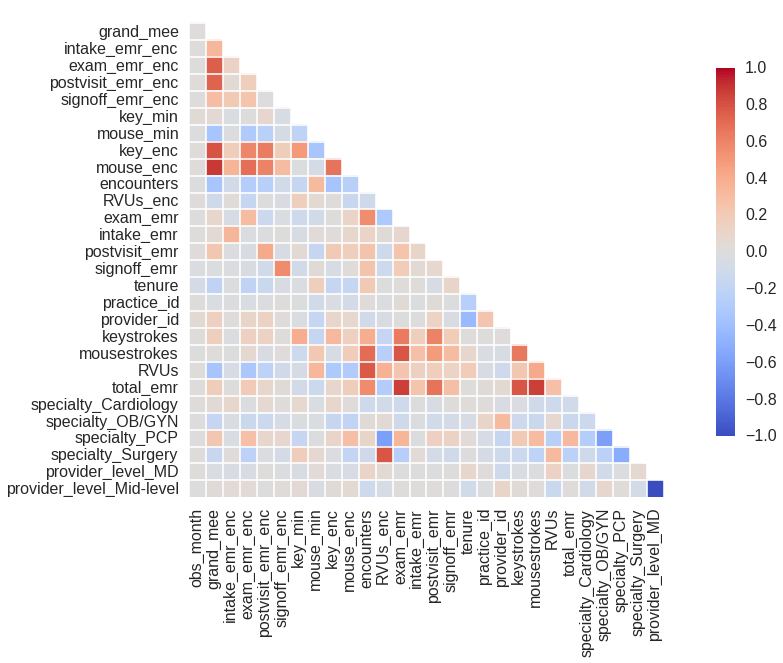

In [718]:
naless = pd.get_dummies(naless)
sns.corrplot(naless, annot=False, diag_names=False)

In [719]:
new_df = pd.get_dummies(naless)
new_df.columns

Index(['obs_month', 'grand_mee', 'intake_emr_enc', 'exam_emr_enc',
       'postvisit_emr_enc', 'signoff_emr_enc', 'key_min', 'mouse_min',
       'key_enc', 'mouse_enc', 'encounters', 'RVUs_enc', 'exam_emr',
       'intake_emr', 'postvisit_emr', 'signoff_emr', 'tenure', 'practice_id',
       'provider_id', 'keystrokes', 'mousestrokes', 'RVUs', 'total_emr',
       'specialty_Cardiology', 'specialty_OB/GYN', 'specialty_PCP',
       'specialty_Surgery', 'provider_level_MD', 'provider_level_Mid-level'],
      dtype='object')

In [796]:
simple_df = pd.get_dummies(naless)
simple_df.rename(columns={'specialty_OB/GYN':'specialty_ob_gyn'}, inplace=True)
simple_df.drop(['intake_emr_enc', 'exam_emr_enc', 'RVUs', 'mouse_enc', 'key_enc', 'keystrokes', 'practice_id',
             'provider_id', 'mousestrokes',
       'postvisit_emr_enc', 'signoff_emr_enc', 'intake_emr', 'postvisit_emr', 'signoff_emr', 'exam_emr',
             'total_emr', ], 
            1, inplace=True)
print(simple_df.columns)

X_simple = simple_df.drop(['grand_mee'], 1).values
y_simple = simple_df.grand_mee

Index(['obs_month', 'grand_mee', 'key_min', 'mouse_min', 'encounters',
       'RVUs_enc', 'tenure', 'specialty_Cardiology', 'specialty_ob_gyn',
       'specialty_PCP', 'specialty_Surgery', 'provider_level_MD',
       'provider_level_Mid-level'],
      dtype='object')


In [736]:
multiplier = ['specialty_Cardiology', 'specialty_ob_gyn', 'specialty_PCP', 
              'specialty_Surgery', 'provider_level_MD', 'provider_level_Mid-level']
multiplied = ['mouse_min', 'key_min', 'RVUs_enc', 'tenure', 'obs_month']

new_df = simple_df

for i in multiplier:
    for j in multiplied:
        new_df['{}_x_{}'.format(i, j)] = new_df[i] * new_df[j]
#         print('{i}_x_{j}'.format(i, j))
#         print(i, "_x_", j, sep="")
        
new_df.columns.values

X_new = new_df.drop(['grand_mee'], 1).values
y_new = new_df.grand_mee

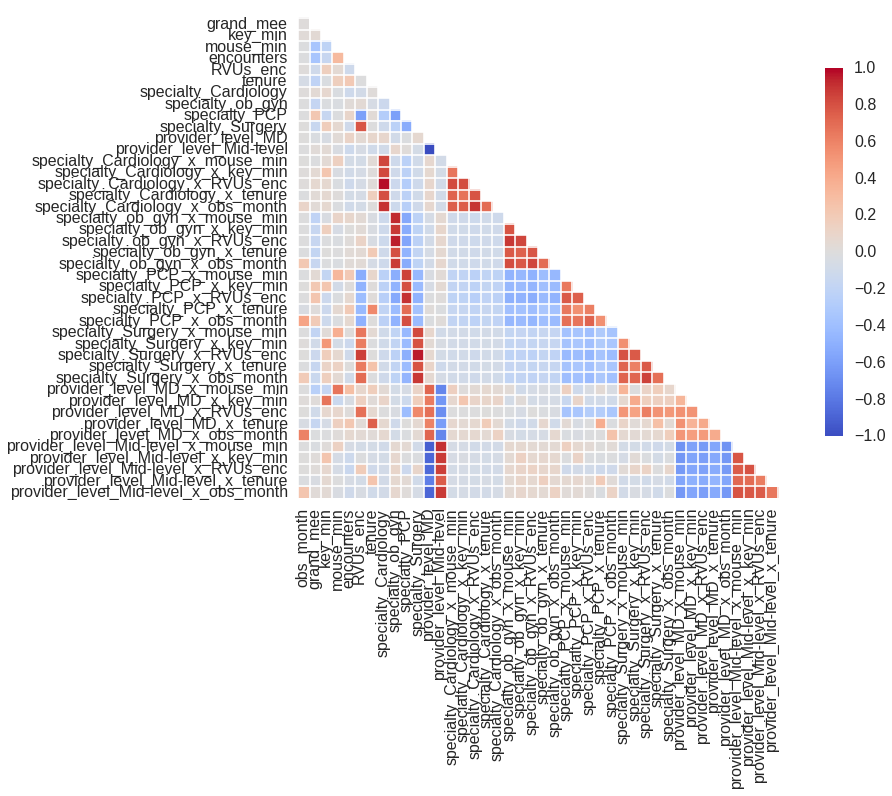

In [703]:
sns.corrplot(new_df, annot=False, diag_names=False)

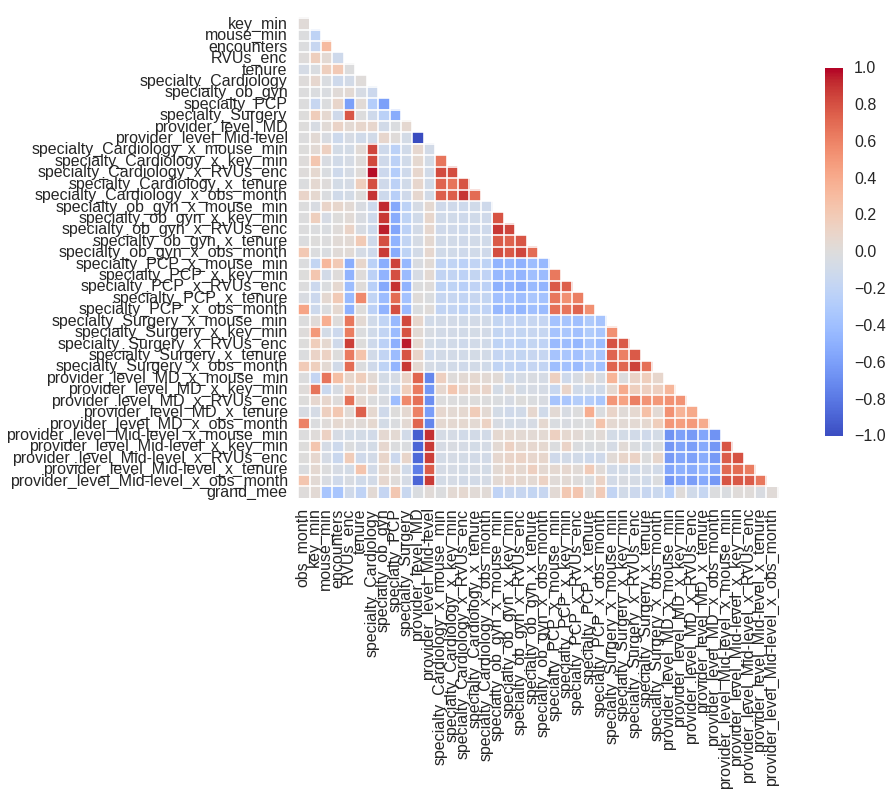

In [708]:
sns.corrplot(df_scaled, annot=False, diag_names=False)

Optimal number of features : 42


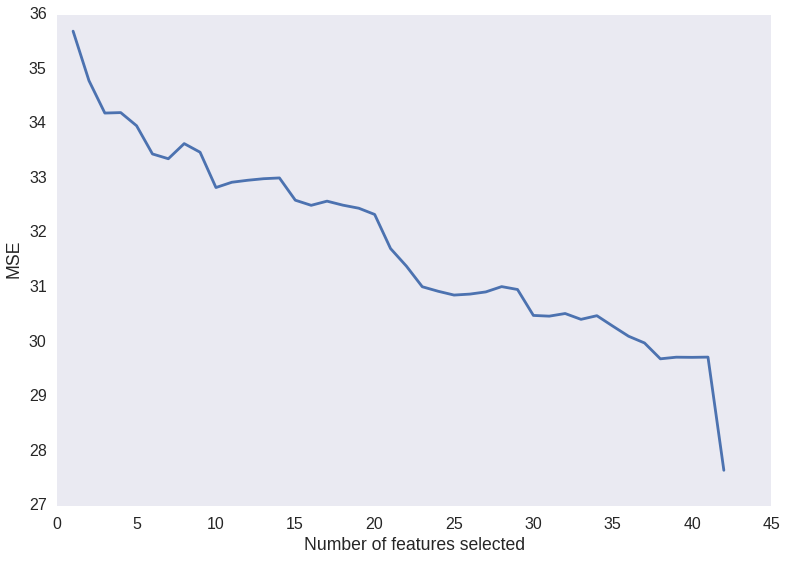

In [738]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

lin_reg = LinearRegression(n_jobs=-1)

rfecv = RFECV(estimator=lin_reg, step=1, cv=11, scoring='mean_squared_error')
rfecv.fit(X_new, y_new)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("MSE")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_)
plt.show()

Optimal number of features : 11


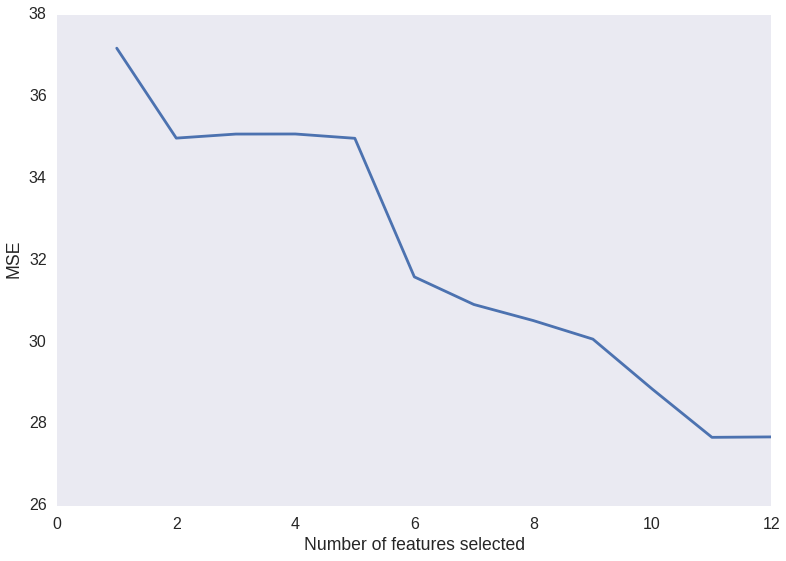

In [739]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

lin_reg = LinearRegression(n_jobs=-1)

rfecv = RFECV(estimator=lin_reg, step=1, cv=11, scoring='mean_squared_error')
rfecv.fit(X_simple, y_simple)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("MSE")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_)
plt.show()

In [667]:
# gbr = GradientBoostingRegressor(verbose=1, n_estimators=1000) # learning_rate=0.01, max_depth=10
# try_model(X_scaled, y, gbr)

# X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_scaled, y, test_size=0.2, random_state=10)

# gbr.fit(X_train, y_train)

In [732]:
# from sklearn.grid_search import GridSearchCV

# est = GradientBoostingRegressor(random_state=10, n_estimators=1000)

# param_grid = { #'n_estimators': [100, 500, 1000],
# #               'loss': ['ls', 'lad'],
# #               'max_depth': [3, 10],
# #               'max_features': [None, 'sqrt'],
# #               'subsample': [0.5, 1]
#               }
 
# gs_cv = GridSearchCV(est, param_grid, n_jobs=-1, verbose=0, cv=5).fit(X_scaled, y)

# print("results:'")
# gs_cv.best_params_

In [734]:
print(X_simple.shape)
print(X_new.shape)

(15938, 42)
(15938, 42)


In [745]:
gbr_simple = GradientBoostingRegressor(n_estimators=1000) # learning_rate=0.01, max_depth=10
# gbr_cv.predict(X_valid)

scores = cross_validation.cross_val_score(gbr_simple, X_simple, y_simple, cv=7, scoring='mean_squared_error', 
                                          n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 28.20301209  13.93691183  34.12970269  46.30351393  13.05353669
  19.92248674  38.39342027]
27.706083463


In [746]:
gbr_new = GradientBoostingRegressor(n_estimators=1000) # learning_rate=0.01, max_depth=10
# gbr_cv.predict(X_valid)

scores = cross_validation.cross_val_score(gbr_new, X_new, y_new, cv=7, scoring='mean_squared_error', n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 27.53327438  12.10912808  30.18989766  47.95737643  12.64665667
  17.9849333   39.40102652]
26.8317561491


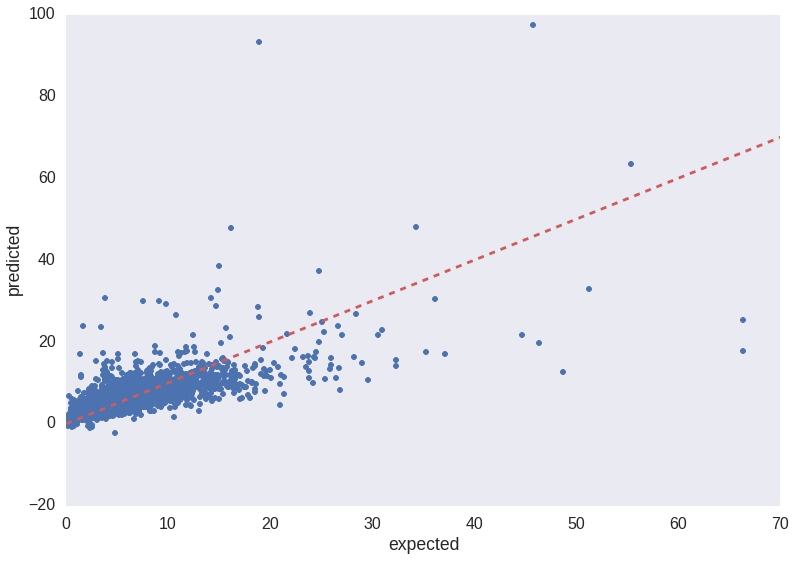

In [747]:
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X_simple, y_simple, test_size=0.15, 
                                                                       random_state=10)

# gbr_simple = GradientBoostingRegressor(n_estimators=1000)
gbr_simple.fit(X_train, y_train)

pred = gbr_simple.predict(X_valid)
plt.plot(y_valid, pred, '.')
plt.xlabel('expected')
plt.ylabel('predicted')
plt.plot(range(71), range(71), '--', c='indianred')

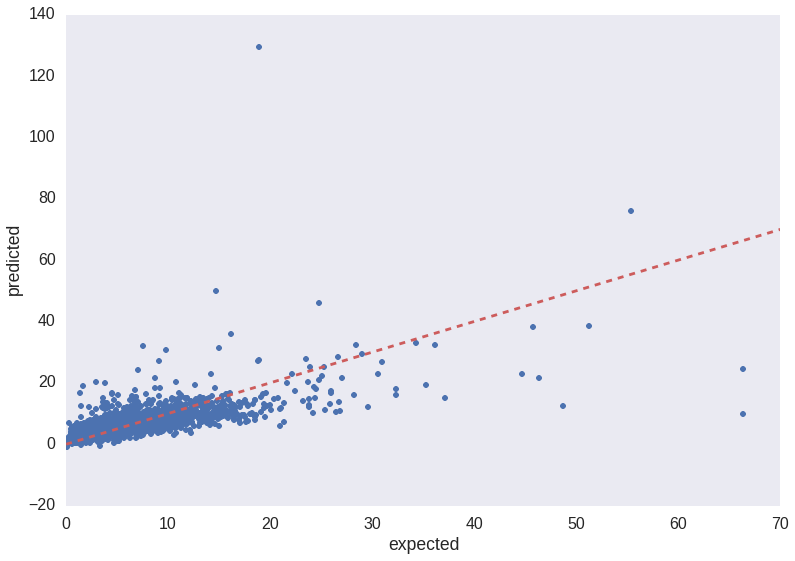

In [748]:
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X_new, y_new, test_size=0.15, 
                                                                       random_state=10)

# gbr_new = GradientBoostingRegressor(n_estimators=1000)
gbr_new.fit(X_train, y_train)

pred = gbr_new.predict(X_valid)
plt.plot(y_valid, pred, '.')
plt.xlabel('expected')
plt.ylabel('predicted')
plt.plot(range(71), range(71), '--', c='indianred')

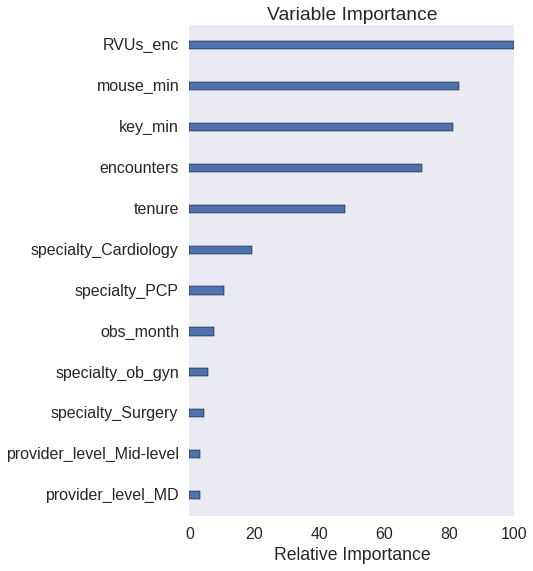

In [751]:
# Plot feature importance

cols = simple_df.drop(['grand_mee'],1).columns

sns.set(context='poster', style='dark')

feature_importance = gbr_simple.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', height=0.2, )
plt.yticks(pos, cols[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

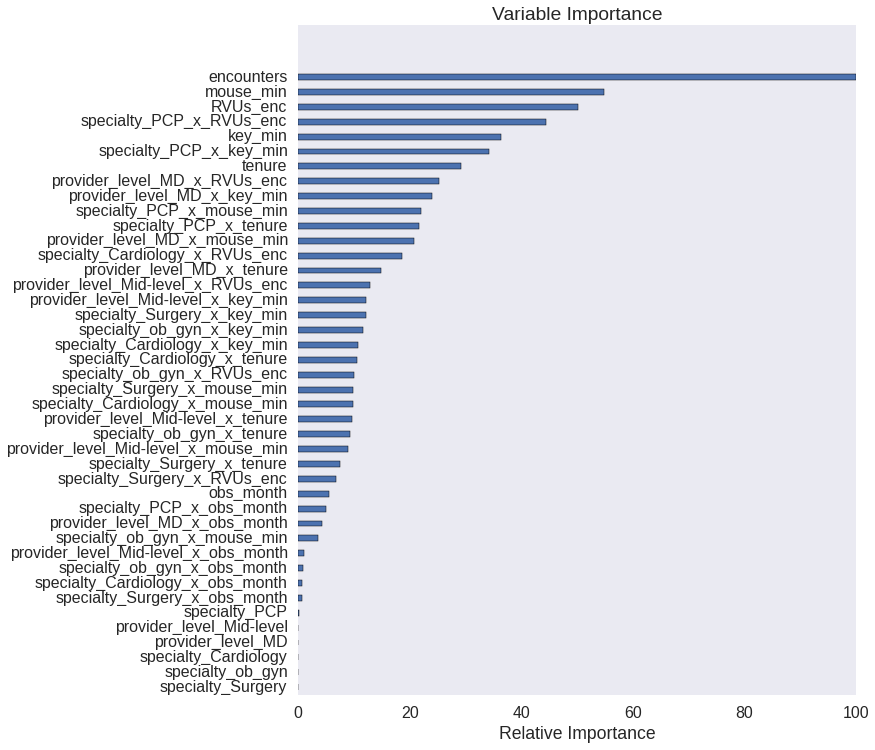

In [823]:
# Plot feature importance

cols = new_df.drop(['grand_mee'],1).columns

sns.set(context='poster', style='dark')

feature_importance = gbr_new.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize = [10, 12])

plt.barh(pos, feature_importance[sorted_idx], align='center', height=0.4, )
plt.yticks(pos, cols[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

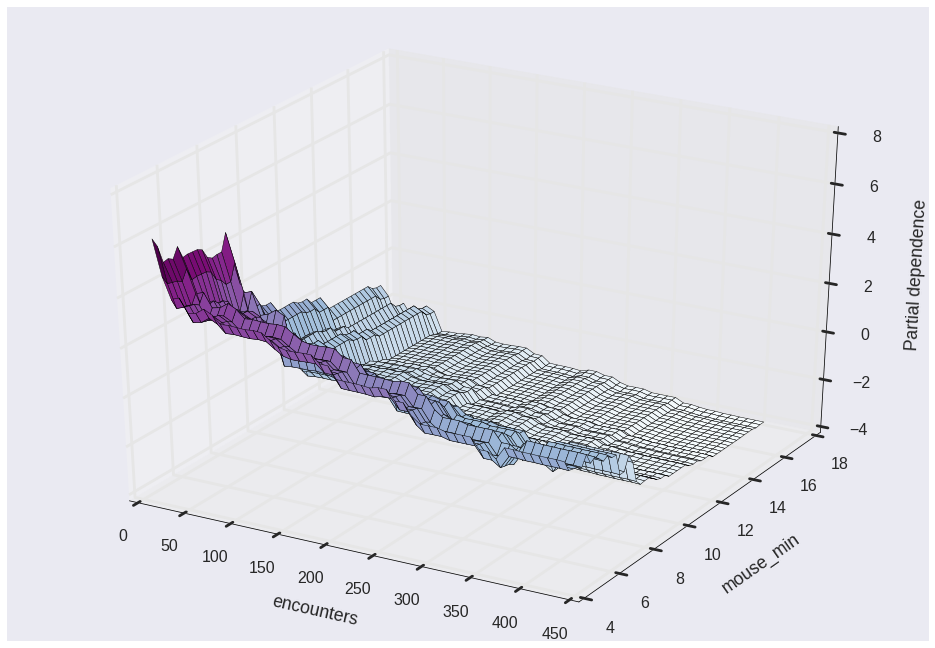

In [835]:
cols = new_df.drop(['grand_mee'], 1, inplace=False).columns.values

feat_imports = dict(zip(cols, gbr_new.feature_importances_))

import operator

feats_sorted = sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)

sort_ix = sorted(range(len(gbr_new.feature_importances_)),key=lambda x:gbr_new.feature_importances_[x], 
                 reverse=True)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

target_feature = sort_ix[:2]
pdp, (x_axis, y_axis) = partial_dependence(gbr_new, target_feature,
                                           X=X_new, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T

fig = plt.figure()

ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(cols[target_feature[0]])
ax.set_ylabel(cols[target_feature[1]])
ax.set_zlabel('Partial dependence')

##linear regression

In [757]:
lin_reg = LinearRegression(n_jobs=-1)

scores = cross_validation.cross_val_score(lin_reg, X_simple, y_simple, cv=7, 
                                          scoring='mean_squared_error', n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 28.48012121  13.46883734  27.76040876  53.13401306  16.10159638
  18.00633564  37.84183749]
27.82759284


In [758]:
lasso_model = Lasso()
# lasso_model.fit(X, y)

scores = cross_validation.cross_val_score(lasso_model, X_simple, y_simple, cv=7,
                                          scoring='mean_squared_error', n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 33.2266383   14.97544655  31.88855884  59.59588825  17.79672661
  18.73131674  37.4524263 ]
30.5238573697


In [759]:
lin_reg = LinearRegression(n_jobs=-1)

scores = cross_validation.cross_val_score(lin_reg, X_new, y_new, cv=7, 
                                          scoring='mean_squared_error', n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 28.2061204   15.19845551  27.9086401   54.06234576  15.94408082
  19.11010375  36.39481161]
28.1177939932


In [760]:
lasso_model = Lasso()
# lasso_model.fit(X, y)

scores = cross_validation.cross_val_score(lasso_model, X_new, y_new, cv=7,
                                          scoring='mean_squared_error', n_jobs=-1)
print(-scores)
print(-scores.mean())

[ 29.60968247  13.46655719  28.97281132  56.37084728  17.30221501
  16.15303034  38.15949832]
28.576377418


In [797]:
simple_df.columns

Index(['obs_month', 'grand_mee', 'key_min', 'mouse_min', 'encounters',
       'RVUs_enc', 'tenure', 'specialty_Cardiology', 'specialty_ob_gyn',
       'specialty_PCP', 'specialty_Surgery', 'provider_level_MD',
       'provider_level_Mid-level'],
      dtype='object')

In [846]:
default_regul_fit = ols_model.fit_regularized(L1_wt=1)

default_regul_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grand_mee   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     83.01
Date:                Tue, 30 Jun 2015   Prob (F-statistic):               0.00
Time:                        05:52:59   Log-Likelihood:                -49089.
No. Observations:               15938   AIC:                         9.831e+04
Df Residuals:                   15874   BIC:                         9.880e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 18.8378      2.289      8.230      0.000        14.351    23.324
obs_month                                                  0.1833      0.591      0.310      0.757        -0.976     1.342
key_min                                                   -0.0215      0.019     -1.117      0.264        -0.059     0.016
obs_month:key_min                                         -0.0040      0.005     -0.786      0.432        -0.014     0.006
mouse_min                                                 -0.9364      0.211     -4.438      0.000        -1.350    -0.523
obs_month:mouse_min                                       -0.0080      0.058     -0.138      0.890        -0.121     0.105
key_min:mouse_min                                          0.0028      0.002      1.464      0.143        -0.001     0.007
obs_month:key_min:mouse_min                             6.808e-05      0.001      0.121      0.904        -0.001     0.001
encounters                                                -0.0015      0.011     -0.130      0.896        -0.024     0.021
obs_month:encounters                                      -0.0003      0.003     -0.099      0.921        -0.005     0.005
key_min:encounters                                      5.819e-07    9.4e-05      0.006      0.995        -0.000     0.000
obs_month:key_min:encounters                            5.413e-06   1.98e-05      0.273      0.785     -3.34e-05  4.42e-05
mouse_min:encounters                                       0.0007      0.001      0.808      0.419        -0.001     0.002
obs_month:mouse_min:encounters                         -2.512e-05      0.000     -0.128      0.898        -0.000     0.000
key_min:mouse_min:encounters                           -6.638e-06   7.47e-06     -0.888      0.374     -2.13e-05  8.01e-06
obs_month:key_min:mouse_min:encounters                   3.06e-07    1.5e-06      0.204      0.839     -2.64e-06  3.25e-06
RVUs_enc                                                   0.2892      0.576      0.502      0.616        -0.840     1.419
obs_month:RVUs_enc                                         0.0757      0.147      0.516      0.606        -0.212     0.364
key_min:RVUs_enc                                          -0.0004      0.004     -0.082      0.935        -0.009     0.008
obs_month:key_min:RVUs_enc                                -0.0001      0.001     -0.092      0.927        -0.002     0.002
mouse_min:RVUs_enc                                        -0.0207      0.052     -0.396      0.692        -0.123     0.082
obs_month:mouse_min:RVUs_enc                               0.0023      0.014      0.168      0.867        -0.024     0.029
key_min:

In [844]:
from statsmodels.formula import api as smf

ols_model = smf.ols(formula='grand_mee ~ obs_month * key_min * mouse_min * encounters * RVUs_enc * tenure', 
                    data=simple_df)
regul_fit = ols_model.fit_regularized(L1_wt=0)

regul_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grand_mee   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     83.01
Date:                Tue, 30 Jun 2015   Prob (F-statistic):               0.00
Time:                        05:47:24   Log-Likelihood:                -49089.
No. Observations:               15938   AIC:                         9.831e+04
Df Residuals:                   15874   BIC:                         9.880e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 18.8378      2.289      8.230      0.000        14.351    23.324
obs_month                                                  0.1833      0.591      0.310      0.757        -0.976     1.342
key_min                                                   -0.0215      0.019     -1.117      0.264        -0.059     0.016
obs_month:key_min                                         -0.0040      0.005     -0.786      0.432        -0.014     0.006
mouse_min                                                 -0.9364      0.211     -4.438      0.000        -1.350    -0.523
obs_month:mouse_min                                       -0.0080      0.058     -0.138      0.890        -0.121     0.105
key_min:mouse_min                                          0.0028      0.002      1.464      0.143        -0.001     0.007
obs_month:key_min:mouse_min                             6.808e-05      0.001      0.121      0.904        -0.001     0.001
encounters                                                -0.0015      0.011     -0.130      0.896        -0.024     0.021
obs_month:encounters                                      -0.0003      0.003     -0.099      0.921        -0.005     0.005
key_min:encounters                                      5.819e-07    9.4e-05      0.006      0.995        -0.000     0.000
obs_month:key_min:encounters                            5.413e-06   1.98e-05      0.273      0.785     -3.34e-05  4.42e-05
mouse_min:encounters                                       0.0007      0.001      0.808      0.419        -0.001     0.002
obs_month:mouse_min:encounters                         -2.512e-05      0.000     -0.128      0.898        -0.000     0.000
key_min:mouse_min:encounters                           -6.638e-06   7.47e-06     -0.888      0.374     -2.13e-05  8.01e-06
obs_month:key_min:mouse_min:encounters                   3.06e-07    1.5e-06      0.204      0.839     -2.64e-06  3.25e-06
RVUs_enc                                                   0.2892      0.576      0.502      0.616        -0.840     1.419
obs_month:RVUs_enc                                         0.0757      0.147      0.516      0.606        -0.212     0.364
key_min:RVUs_enc                                          -0.0004      0.004     -0.082      0.935        -0.009     0.008
obs_month:key_min:RVUs_enc                                -0.0001      0.001     -0.092      0.927        -0.002     0.002
mouse_min:RVUs_enc                                        -0.0207      0.052     -0.396      0.692        -0.123     0.082
obs_month:mouse_min:RVUs_enc                               0.0023      0.014      0.168      0.867        -0.024     0.029
key_min:

### simple ANN

In [78]:
from lasagne import layers

from lasagne.nonlinearities import softmax
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import tanh
from lasagne.nonlinearities import sigmoid
from lasagne.nonlinearities import *
from lasagne.nonlinearities import identity

from nolearn.lasagne import NeuralNet

try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
except ImportError:
    Conv2DLayer = layers.Conv2DLayer
    MaxPool2DLayer = layers.MaxPool2DLayer

In [22]:
num_features=X.shape[1]
np.shape(X)

(15938, 63)

In [15]:
np.shape(Y)

(15938,)

In [96]:
X = np.float32(X)
Y = np.float32(Y)

y = Y.reshape((15938, 1))

In [101]:
print(np.shape(X))
print(np.shape(y))
print(y)

(15938, 63)
(15938, 1)
[[ 11.12250042]
 [ 11.54466152]
 [ 11.73053837]
 ..., 
 [  0.10061856]
 [  0.0957732 ]
 [  0.09392857]]


In [120]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X)
X

array([[ 0.69177812, -0.42161793,  0.10916066, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [ 0.72002095, -0.46107289,  0.22054294, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [ 0.75919199, -0.45438841,  0.24568458, ..., -0.40173346,
        -0.49042198, -0.43319139],
       ..., 
       [-1.16484582,  4.75250626, -0.95760095, ..., -0.40173346,
        -0.49042198, -0.43319139],
       [-1.17528379,  3.99595666, -0.9581989 , ..., -0.40173346,
        -0.49042198, -0.43319139],
       [-1.15957713,  5.81618404, -0.9582212 , ..., -0.40173346,
        -0.49042198, -0.43319139]], dtype=float32)

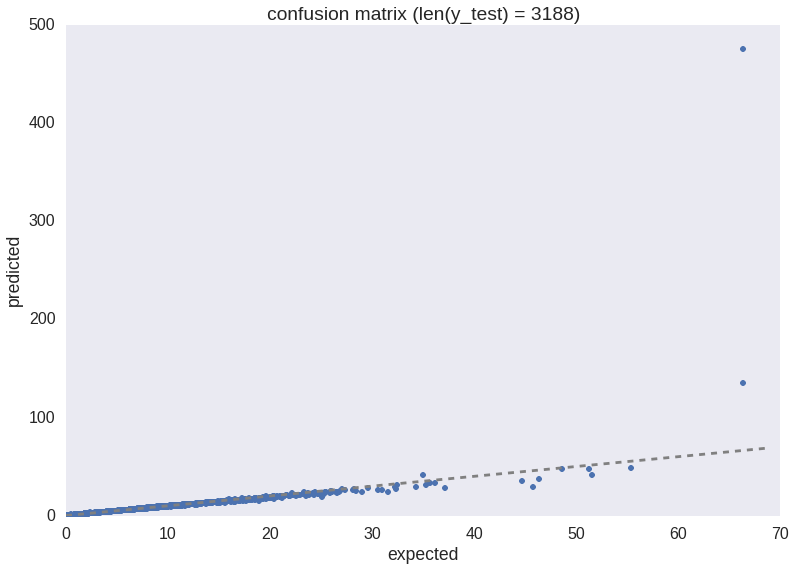

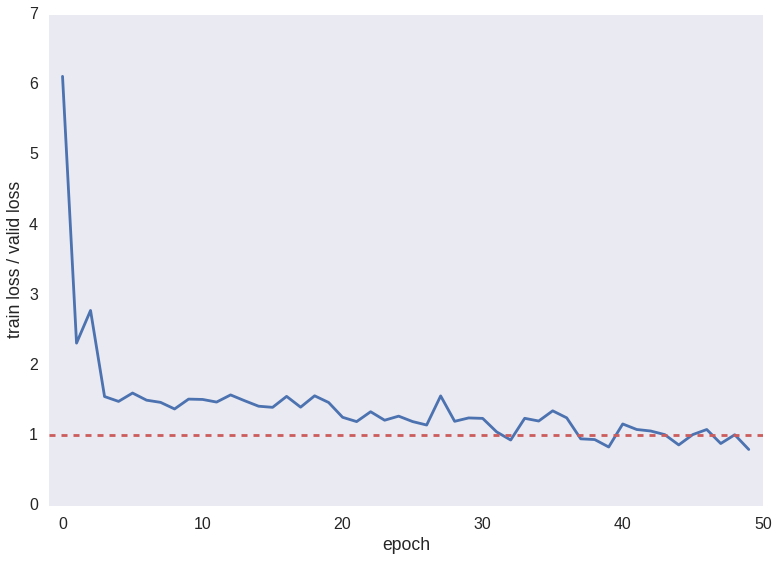

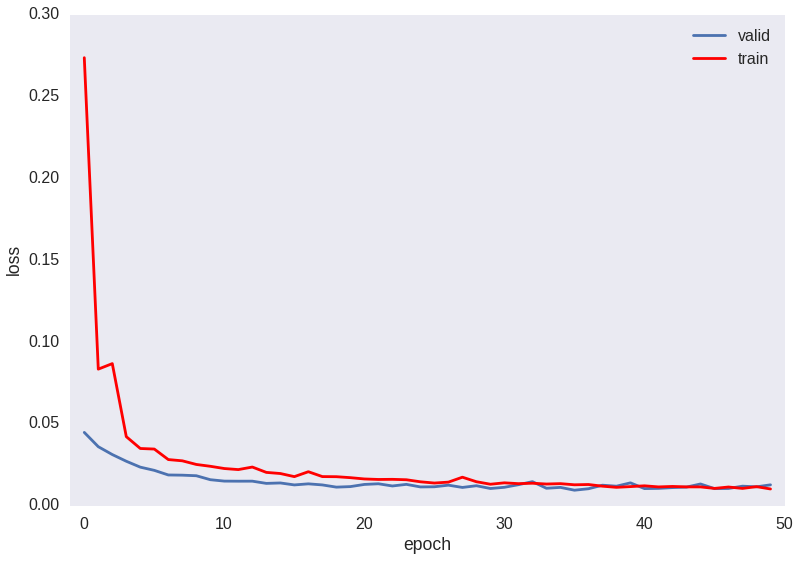

In [313]:
# [ valid_losses[i['epoch']-1] = i['valid_loss'] for i in net0.train_history_]
    
# net0.train_history_[0]['train_loss']

# for i in net0.train_history_:
#     print(i['epoch']-1)

# sns.set(context='poster', style='dark')

def plot_training_history(model):
    
    sns.set(context='poster', style='dark')
    
    valid_losses = np.array([ i['valid_loss'] for i in model.train_history_ ])
    train_losses = np.array([ i['train_loss'] for i in model.train_history_ ])

    plt.figure()
    plt.plot(train_losses/valid_losses)
    plt.plot([-1, len(train_losses)], [1, 1], '--', c='indianred')
    plt.ylabel('train loss / valid loss')
    plt.xlabel('epoch')
    plt.xlim([-1, len(train_losses)])


    plt.figure()
    plt.plot(valid_losses, label='valid')
    plt.plot(train_losses, 'r', label='train')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xlim([-1, len(train_losses)])
    plt.legend(loc='best')

    
def plot_confusion_matrix(X_test, y_test, model):
    plt.plot(y_test, np.e**model.predict(X_test), '.')
    plt.xlabel('expected')
    plt.ylabel('predicted')
    
    max_num = np.max([np.max(y_test), np.max(np.e**model.predict(X_test))])
    
#     plt.xlim([0, max_num])
#     plt.ylim([0, max_num])

    plt.plot(range(70), range(70), '--', c='gray')
    plt.title('confusion matrix (len(y_test) = {})'.format(len(y_test)))
    
plot_confusion_matrix(X_test, y_test, net0)
plot_training_history(net0)

In [130]:
y.mean()

6.6958966

In [132]:
X_rand = np.float32(rand(15938, 63)-0.5)
y_rand = np.float32(rand(15938, 1)*10)
X_rand.mean()
y_rand.mean()

5.0178251

In [322]:
print(np.min(y), np.max(y))
print(np.min(np.log(y)), np.max(np.log(y)))

0.025692 203.95
-3.66158 5.31787


  input             	(None, 63)          	produces      63 outputs
  dense0            	(None, 500)         	produces     500 outputs
  dropout1          	(None, 500)         	produces     500 outputs
  dense1            	(None, 500)         	produces     500 outputs
  dropout2          	(None, 500)         	produces     500 outputs
  dense2            	(None, 500)         	produces     500 outputs
  output            	(None, 1)           	produces       1 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.302043  |    0.042758  |     7.064010  |             |  12.8s
     2  |    0.058102  |    0.029335  |     1.980681  |             |  13.1s
     3  |    0.095742  |    0.025650  |     3.732712  |             |  13.3s
     4  |    0.053346  |    0.022531  |     2.367736  |             |  13.3s
     5  |    0.056023  |    0.020982  |     2.669998  |             | 

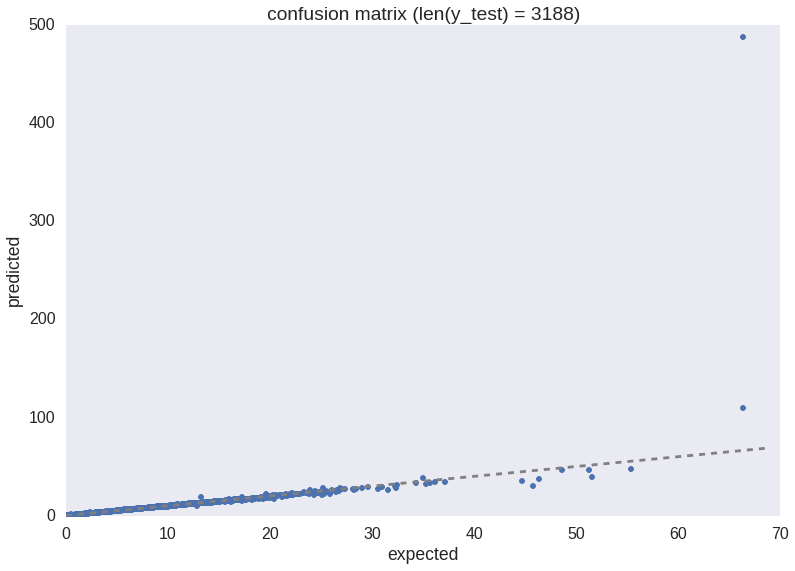

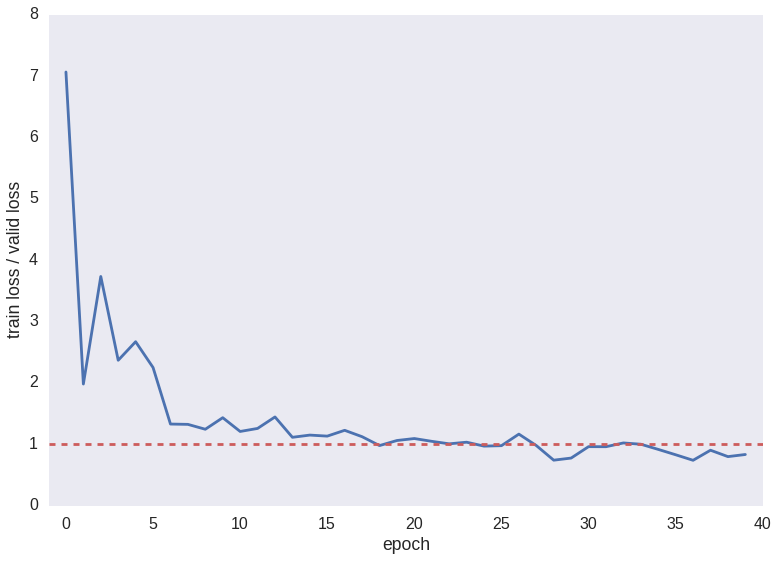

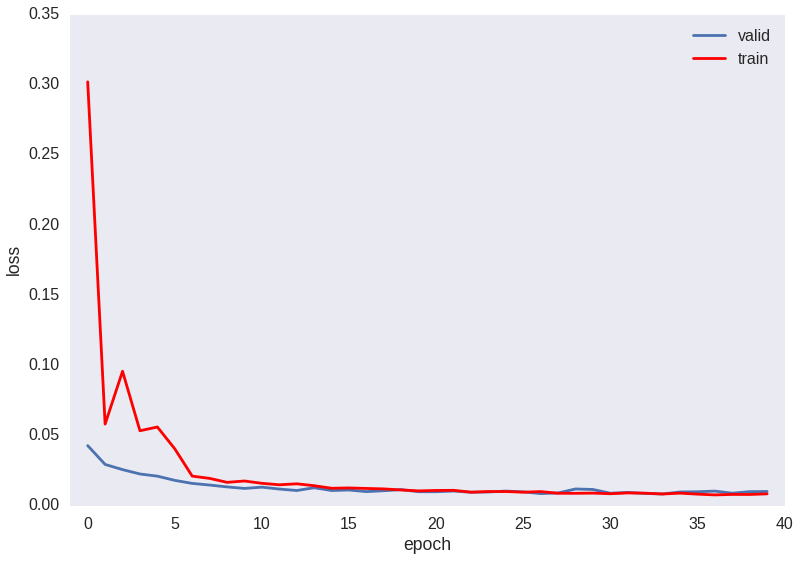

In [316]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=10)

layers0 = [('input', layers.InputLayer),
           ('dense0', layers.DenseLayer),
           ('dropout1', layers.DropoutLayer),
           ('dense1', layers.DenseLayer),
           ('dropout2', layers.DropoutLayer),
           ('dense2', layers.DenseLayer),
           ('output', layers.DenseLayer)]


net0 = NeuralNet(layers=layers0,
             input_shape=(None, num_features),
             dense0_num_units=500,  # 750 -> close to .47
             dropout1_p=0.1,
             dense1_num_units=500,
             dropout2_p=0.1,
             dense2_num_units=500,
             
             output_num_units=1,
             output_nonlinearity=None,
             update_learning_rate=0.01,
             update=nesterov_momentum,
             update_momentum=0.9,
             regression=True,
             eval_size=0.2,
             verbose=1,
             max_epochs=50)

net0.fit(X_train, np.log(y_train))
print("5: mse:  1.16102709934")
print("mse: ", np.median(np.sqrt((y - np.e**net0.predict(X))**2)))

plot_confusion_matrix(X_test, y_test, net0)
plot_training_history(net0)